<a href="https://colab.research.google.com/github/rubanzasilva/abalone_age_prediction/blob/dev/ps_s04e04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Imports

#####FastKaggle dataset import

In [ ]:
# install fastkaggle if not available
try: import fastkaggle
except ModuleNotFoundError:
    !pip install -Uq fastkaggle

from fastkaggle import *

In [ ]:
creds = '{"username":"rubanzasilva","key":"a813913345e829b9b4019a3267ede370"}'

cred_path = Path('~/.kaggle/kaggle.json').expanduser()
if not cred_path.exists():
    cred_path.parent.mkdir(exist_ok=True)
    cred_path.write_text(creds)
    cred_path.chmod(0o600)

In [ ]:
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle: path = Path('../input/playground-series-s4e4')
else:
    import zipfile,kaggle
    path = Path('playground-series-s4e4')
    kaggle.api.competition_download_cli(str(path))
    zipfile.ZipFile(f'{path}.zip').extractall(path)

#train_df = pd.read_csv(path/'train.csv')
#test_df = pd.read_csv(path/'test.csv')

In [ ]:
comp = 'playground-series-s4e4'

path = setup_comp(comp, install='fastai "timm>=0.6.2.dev0"')

IndexError: tuple index out of range

#####Imports

In [11]:
#hide
#! [ -e /content ]

#hide
#This imports and sets up everything you will need for this notebook
#
#!pip install -Uqq fastbook
#import fastbook
#fastbook.setup_book()

#from fastbook import *
from fastai.tabular.all import *
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from numpy import random

from fastai.imports import *
np.set_printoptions(linewidth=130)


from pathlib import Path
import os


from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

import xgboost as xgb
from xgboost import plot_importance


from ipywidgets import interact


matplotlib.rc('image', cmap='Greys')

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'playground-series-s4e4:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F72489%2F8096274%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240408%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240408T075311Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D48a600986c6eb15cdb3e2de08126dd7ae24bb9d2e9ed70fb39ba7234f8bdf30f7625b133bd759917cbf61055e9c75737294b83cebe75061937b8e69dedf5da734366fb458588039b4cf422acab0ff5eaba6b30e74a692b35aa1ddd181868b2ef1d14ff3535f4dfe214f962000bf2b967d7cdf76343433ea8d6eb71ef02a772a66e6b0e2012c0aadb08b04260dfa39a1d8dd66a665782a3631bd81283ae3eaaeb6b683bb1c6e4d06bf6cbcf3ec5850728e6aaaebf2eeb3963bc378f68cfc158d2e7430762ab5b340033a1de5ffb8a6ea0458c218317a012eec36f0be7266749035cb367a949eeba5b64f13f57434c002d336496e47a0c603709e6e6207f6d3960'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 2529839 bytes downloaded
Downloaded and uncompressed: playground-series-s4e4
Data source import complete.


In [2]:
#comp = 'playground-series-s4e4'

In [3]:
!ls /kaggle/input/playground-series-s4e4

sample_submission.csv  test.csv  train.csv


In [4]:
!ls

sample_data


In [5]:
# Next, install the Kaggle API client.
#!pip install -q kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rubanzasilva","key":"7590231111c5bbe2ad242827b0ef016c"}'}

In [6]:

 ! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

# List available datasets.
#!kaggle datasets list


Set random seed for reproducibility.

In [7]:
#set_seed(42)

In [12]:
path = Path('/kaggle/input/playground-series-s4e4/')
path

Path('/kaggle/input/playground-series-s4e4')

###Index_col

With or without.

I remove the index_col because it changes the shape of our original dataset.
 Later on we shall be able to investigate the effect of this action.

In [13]:
#train_df = pd.read_csv(path/'train.csv',index_col='id')

train_df = pd.read_csv(path/'train.csv',index_col='id')
test_df = pd.read_csv(path/'test.csv',index_col='id')
sub_df = pd.read_csv(path/'sample_submission.csv',index_col='id')


In [9]:

#train_df = pd.read_csv(path/'train.csv',index_col='id')

#train_df = pd.read_csv(path/'train.csv')
#test_df = pd.read_csv(path/'test.csv')
#sub_df = pd.read_csv(path/'sample_submission.csv')


In [14]:
train_df.head()

,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
id,,,,,,,,,
0,F,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400,11
1,F,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200,11
2,I,0.160,0.110,0.025,0.0210,0.0055,0.0030,0.0050,6
3,M,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500,10
4,I,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975,9


####Initial Exploratory Data Analysis

In [ ]:
train_df.describe(include=[object])

,Sex
count,90615
unique,3
top,I
freq,33093


In [ ]:
train_df.describe()

,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
count,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000
mean,0.517098,0.401679,0.135464,0.789035,0.340778,0.169422,0.225898,9.696794
std,0.118217,0.098026,0.038008,0.457671,0.204428,0.100909,0.130203,3.176221
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,0.445000,0.345000,0.110000,0.419000,0.177500,0.086500,0.120000,8.000000
50%,0.545000,0.425000,0.140000,0.799500,0.330000,0.166000,0.225000,9.000000
75%,0.600000,0.470000,0.160000,1.067500,0.463000,0.232500,0.305000,11.000000
max,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000


In [ ]:
dep_classes_count = train_df['Rings'].value_counts()
dep_classes_count

Rings
9     17465
8     14499
10    12464
7      9008
11     8407
6      5411
12     4719
13     4074
5      2862
14     2507
15     2072
16     1439
4      1402
17     1175
18      848
19      639
20      507
3       386
21      255
23      180
22      108
27       41
2        29
24       29
1        25
29       24
25       22
26       18
Name: count, dtype: int64

<Axes: >

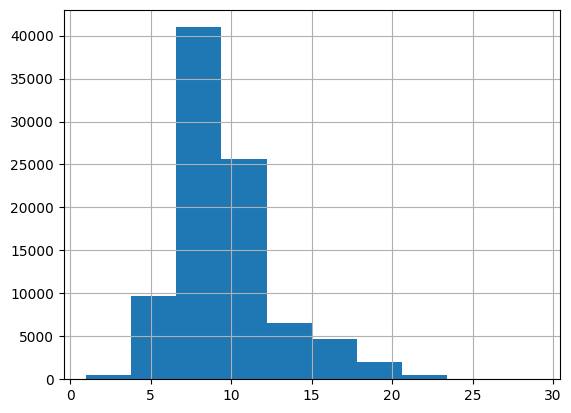

In [ ]:
train_df['Rings'].hist()

In [ ]:
dep_classes_count = train_df['Diameter'].value_counts()
dep_classes_count

Diameter
0.4500    4182
0.4750    3307
0.4550    2715
0.4000    2667
0.4700    2441
          ... 
0.0750       1
0.0550       1
0.3755       1
0.6500       1
0.1130       1
Name: count, Length: 126, dtype: int64

<Axes: >

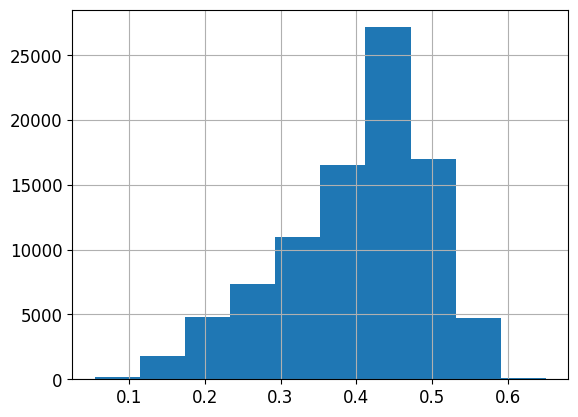

In [ ]:
train_df['Diameter'].hist()

<Axes: ylabel='count'>

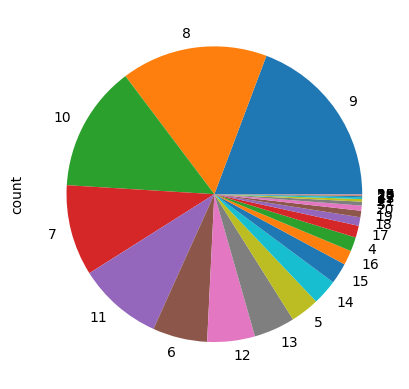

In [ ]:
dep_classes_count.plot(kind='pie')

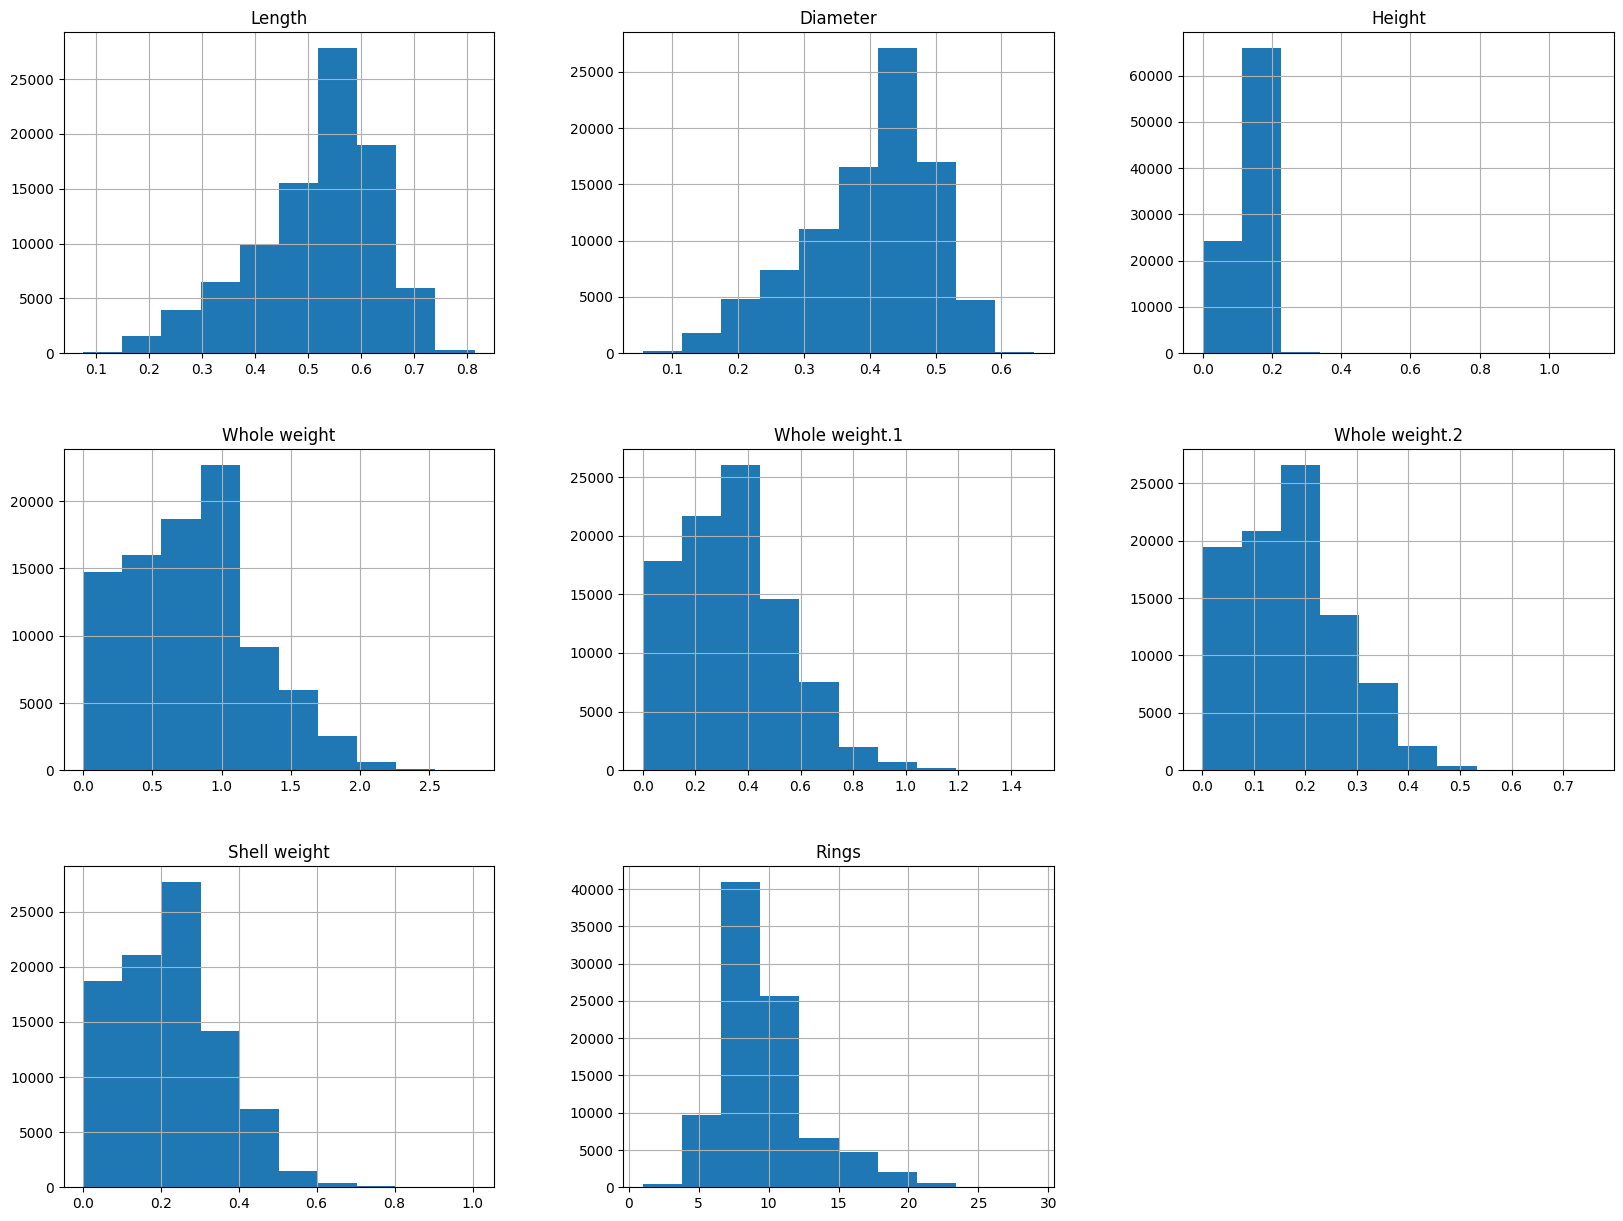

In [ ]:
train_df.hist(figsize=(20,15));

####TabularPandas Object


We create an instance of a TabularPandas Object,to which is a fastai dataframe wrapper that stores all the information about our dataset such as which columns are continous, categorical, and our dependent variables.

This instance also stores and applies the set transformations to our data.

In [15]:
cont_names,cat_names = cont_cat_split(train_df, dep_var='Rings')

In [16]:
splits = RandomSplitter(valid_pct=0.2)(range_of(train_df))

In [17]:
to = TabularPandas(train_df, procs=[Categorify, FillMissing,Normalize],
                   cat_names = cat_names,
                   cont_names = cont_names,
                   y_names='Rings',
                   y_block=RegressionBlock(),
                   splits=splits)

In [18]:
to.xs.iloc[:2]

,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight
id,,,,,,,,
50954,2,0.024942,-0.118767,-0.406839,-0.455260,-0.404324,-0.642939,-0.582298
11595,3,0.617129,0.748105,0.384746,0.293597,0.556335,0.436760,0.223109


In [19]:
dls = to.dataloaders(bs=64)

In [20]:
dls.show_batch()

,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
0,I,0.140,0.105,0.035,0.0105,0.0050,0.0025,0.0035,4.0
1,F,0.595,0.440,0.150,0.9955,0.4545,0.2290,0.2950,9.0
2,M,0.595,0.470,0.135,1.0295,0.4560,0.2040,0.2600,10.0
3,I,0.385,0.300,0.095,0.2530,0.0965,0.0515,0.0800,8.0
4,M,0.530,0.405,0.125,0.8115,0.3045,0.1820,0.2020,10.0
5,F,0.590,0.455,0.135,0.9660,0.4655,0.2095,0.2650,8.0
6,F,0.565,0.440,0.140,0.7850,0.3285,0.1705,0.2380,12.0
7,I,0.385,0.305,0.090,0.3140,0.1605,0.0525,0.0850,7.0
8,I,0.285,0.210,0.070,0.1185,0.0480,0.0285,0.0300,6.0
9,M,0.640,0.510,0.500,1.3715,0.5065,0.3050,0.4700,12.0


In [21]:
learn = tabular_learner(dls, metrics=rmse)

SuggestedLRs(slide=6.309573450380412e-07, valley=0.005248074419796467)

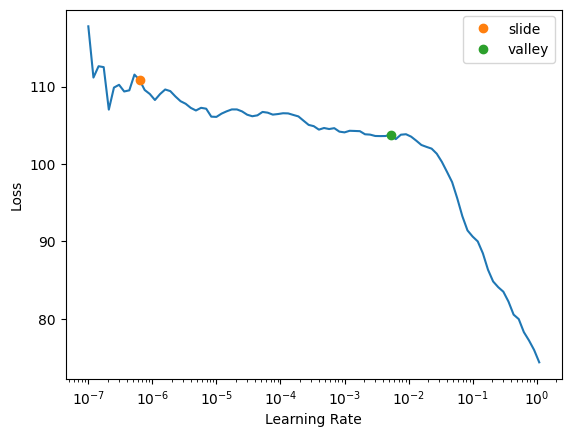

In [22]:
learn.lr_find(suggest_funcs=(slide,valley))

In [23]:
learn.fit_one_cycle(6,slice(6.309573450380412e-05, 0.002054606556892395))

epoch,train_loss,valid_loss,_rmse,time
0,3.890613,3.772245,1.942227,00:12
1,3.836300,3.792751,1.947499,00:12
2,3.816330,3.738108,1.933419,00:18
3,3.736127,3.634018,1.906310,00:12
4,3.760381,3.597374,1.896674,00:12
5,3.618857,3.614995,1.901314,00:12


In [ ]:
#learn.fit_one_cycle(15,slice(6.309573450380412e-07, 0.019054606556892395))

epoch,train_loss,valid_loss,_rmse,time
0,3.926951,4.539420,2.130592,00:14
1,3.841202,3.569802,1.889392,00:17
2,3.627239,3.536179,1.880473,00:13


In [ ]:
learn.show_results()

,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings,Rings_pred
0,2.0,-1.246327,-1.294165,-0.932470,-1.055313,-0.968280,-1.169639,-1.148723,7.0,6.951717
1,2.0,-1.839044,-1.753669,-1.588681,-1.442307,-1.394069,-1.402594,-1.506319,6.0,5.877190
2,3.0,0.193129,0.135400,-0.145017,0.188753,0.142687,0.366870,-0.006724,9.0,9.790660
3,3.0,1.124542,1.207574,0.379952,1.061129,0.747111,0.951735,0.654636,9.0,10.383004
4,2.0,-0.399588,-0.630439,-0.013775,-0.601634,-0.537597,-0.589731,-0.737296,6.0,8.076536
5,2.0,-0.187903,-0.273047,-0.538744,-0.591795,-0.515574,-0.525297,-0.583491,7.0,8.199657
6,2.0,-0.314914,-0.273047,-0.801228,-0.456238,-0.422585,-0.763208,-0.737296,8.0,7.687397
7,3.0,-0.230240,-0.273047,-0.407502,-0.591795,-0.584091,-0.327037,-0.429687,11.0,9.065765
8,3.0,1.166878,1.462854,1.298647,1.032706,0.534217,0.951735,0.993006,13.0,13.253347


In [ ]:
#row, clas, probs = learn.predict(df.iloc[0])
#row.show()

In [25]:
dl = learn.dls.test_dl(test_df)

In [26]:
nn_preds = learn.get_preds(dl=dl)
nn_preds

(tensor([[ 9.4949],
         [ 9.9343],
         [10.2973],
         ...,
         [12.5931],
         [13.3690],
         [ 8.6724]]),
 None)

In [27]:
a_preds, _ = learn.get_preds(dl=dl)

In [28]:
nn_preds_y = a_preds.squeeze(1)
nn_preds_y

tensor([ 9.4949,  9.9343, 10.2973,  ..., 12.5931, 13.3690,  8.6724])

In [29]:
nn_preds_y.shape

torch.Size([60411])

In [30]:
nn_preds_x = learn.get_preds()[0]
nn_preds_x

tensor([[ 8.1183],
        [ 8.0589],
        [10.7894],
        ...,
        [13.7487],
        [10.7930],
        [ 8.6205]])

In [31]:
nn_preds_x.shape

torch.Size([18123, 1])

In [32]:
#nn_argmax = nn_preds_x.argmax(dim=1)
#nn_argmax

In [33]:
X_train, y_train = to.train.xs, to.train.ys.values.ravel()
X_test, y_test = to.valid.xs, to.valid.ys.values.ravel()

In [34]:
rmse(nn_preds_x, tensor(y_test))

TensorBase(1.9013)

In [ ]:
!ls

models	sample_data


In [ ]:
#target_preds = nn_preds[0]

In [ ]:
#test_df['Rings'] = target_preds

#test_df.to_csv('submission.csv', columns=['id','Rings'], index=False)

#submission = pd.read_csv('submission.csv')
#submission.head()

,id,Rings
0,90615,9.415621
1,90616,9.716002
2,90617,10.297346
3,90618,10.079777
4,90619,7.675570


In [51]:
ls

kaggle.json  models/  sample_data/


In [ ]:
#!kaggle competitions submit -c playground-series-s4e4 -f submission.csv -m "Neural Network Sub 3 with id column + no random seed "

100% 964k/964k [00:00<00:00, 4.03MB/s]
Successfully submitted to Regression with an Abalone Dataset

####Neural Network without id column

In [52]:
target_preds = nn_preds[0]

test_df['Rings'] = target_preds

test_df.to_csv('submission.csv', columns=['Rings'], index=True, index_label='id')

submission = pd.read_csv('submission.csv')
submission.head()

,id,Rings
0,90615,9.494860
1,90616,9.934261
2,90617,10.297255
3,90618,9.944864
4,90619,7.782946


In [53]:
!kaggle competitions submit -c playground-series-s4e4 -f submission.csv -m "Neural Network Sub 5 with no id column + no random seed for ensemble compariuson "

100% 964k/964k [00:01<00:00, 776kB/s]
Successfully submitted to Regression with an Abalone Dataset

###Neural Network Ensemble

SuggestedLRs(slide=2.0892961401841603e-05, valley=0.00363078061491251)

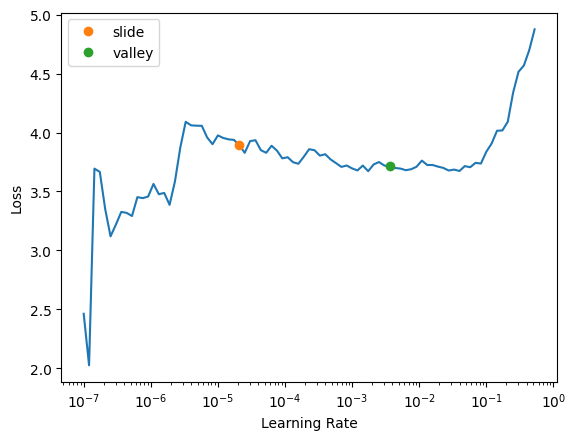

In [35]:
learn.lr_find(suggest_funcs=(slide,valley))

In [37]:
dl = learn.dls.test_dl(test_df)

In [38]:
def ensemble():
    learn = tabular_learner(dls, metrics=rmse)
    with learn.no_bar(),learn.no_logging(): learn.fit(9, slice(2.0992961401841603e-03,0.00263078061491251))
    return learn.get_preds(dl=dl)[0]

In [39]:
learns = [ensemble() for _ in range(5)]

In [40]:
ens_preds = torch.stack(learns).mean(0)

In [41]:
ens_preds, _ = learn.get_preds(dl=dl)

In [42]:
ens_preds_y = ens_preds.squeeze(1)
ens_preds_y

tensor([ 9.4949,  9.9343, 10.2973,  ..., 12.5931, 13.3690,  8.6724])

In [43]:
ens_preds_y[0]

tensor(9.4949)

In [44]:
#target_preds = ens_preds_y[0]

#test_df['Rings'] = target_preds

#test_df.to_csv('submission.csv', columns=['Rings'], index=True, index_label='id')

#submission = pd.read_csv('submission.csv')
#submission.head()

,id,Rings
0,90615,tensor(9.4949)
1,90616,tensor(9.4949)
2,90617,tensor(9.4949)
3,90618,tensor(9.4949)
4,90619,tensor(9.4949)


In [48]:
target_preds = ens_preds_y

test_df['Rings'] = target_preds

test_df.to_csv('submission.csv', columns=['Rings'], index=True, index_label='id')

submission = pd.read_csv('submission.csv')
submission.head()

,id,Rings
0,90615,9.494860
1,90616,9.934261
2,90617,10.297255
3,90618,9.944864
4,90619,7.782946


In [49]:
!ls

kaggle.json  models  sample_data  submission.csv


In [50]:
!kaggle competitions submit -c playground-series-s4e4 -f submission.csv -m "Neural Network ensemble preds Sub 2 with no id column + no random seed "

100% 964k/964k [00:00<00:00, 1.46MB/s]
Successfully submitted to Regression with an Abalone Dataset

In [ ]:
submission = pd.DataFrame({
     # Assuming 'Id' is the identifier column
    'target': ens_preds
})

# Save your submission to a CSV file
submission.to_csv('submission.csv', index=False)

In [ ]:
def subm(preds, suff):
    test_df['Rings'] = preds
    sub_df = test_df[['id','Rings']]
    sub_df.to_csv(f'sub{suff}.csv', index=False)

subm(ens_preds, 'mission')

In [ ]:
#sub_df = pd.DataFrame(ens_preds, columns='Rings')
#sub_df['id'] = test_df['id']

# Reorder the columns to match the submission format
#sub_df = sub_df[['id', 'Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults']]

# Save the submission DataFrame as a CSV file
#sub_df.to_csv('rf_submission.csv', index=False)

In [ ]:
#targets ='Rings'
#test_df[targets] = ens_preds
#sub_df['id'] = test_df['id']

#test_df.to_csv('submission.csv', columns=['Rings'], index=False)

#ens_sub = pd.read_csv('submission.csv')
#ens_sub.head()

###Random Forest

In [78]:
X_train, y_train = to.train.xs, to.train.ys.values.ravel()
X_test, y_test = to.valid.xs, to.valid.ys.values.ravel()

In [79]:
rf = RandomForestClassifier(100, min_samples_leaf=5)
rf.fit(X_train, y_train);
#mean_absolute_error(y_test, rf.predict(X_test))

#roc_auc_score(y_test, rf.predict(X_test))

In [ ]:
#rf_preds = rf.predict(X_test)

In [ ]:
#rmse(rf_preds, tensor(y_test))

Feature Importance

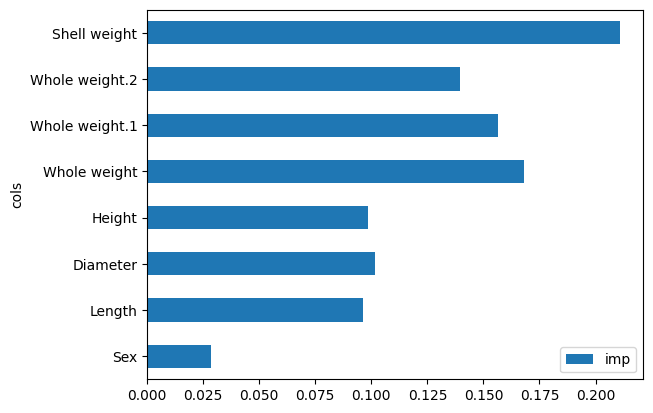

In [80]:
pd.DataFrame(dict(cols=X_train.columns, imp=rf.feature_importances_)).plot('cols', 'imp', 'barh');

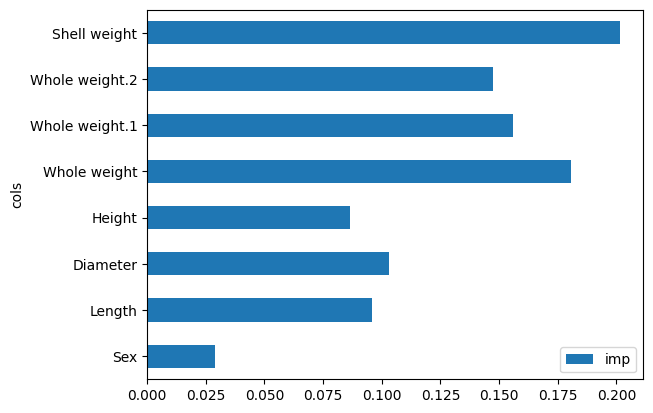

In [ ]:
pd.DataFrame(dict(cols=X_train.columns, imp=rf.feature_importances_)).plot('cols', 'imp', 'barh');

Shell weight and Whole weight seem to be the most importatant features closely followed by Whole Weight. 1 And Whole Weight. 2.

Sex seems to be the least important predictor.

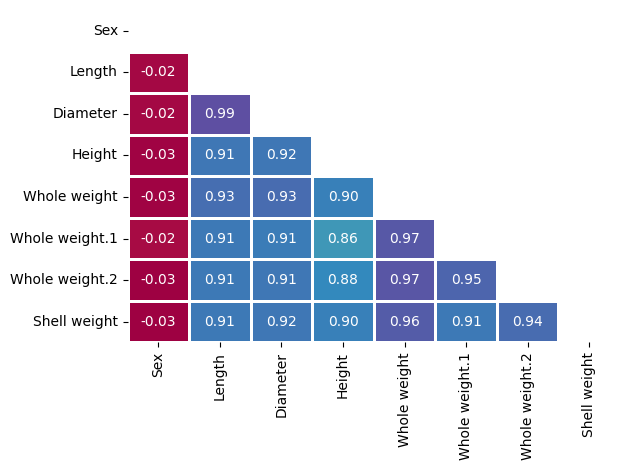

In [ ]:
# Training dataset
numeric_columns_train = X_train.select_dtypes(include=np.number)
corr_train = numeric_columns_train.corr(method='pearson')
mask_train = np.triu(np.ones_like(corr_train))
sns.heatmap(corr_train, annot=True, fmt='.2f', mask=mask_train, cmap='Spectral', cbar=None, linewidth=2)
plt.tight_layout()
plt.show()

Darker Colors: Indicate stronger correlations. The closer the color is to the maximum intensity (e.g., red or orange for positive correlations, blue or green for negative correlations), the stronger the correlation 1.


Lighter Colors: Indicate weaker correlations. The closer the color is to the minimum intensity (e.g., white or light blue), the weaker the correlation 1.

Try dropping sex column.
or Diameter
or diameter and whole weight

In [ ]:
from fastai.tabular.all import cluster_columns

In [ ]:
cluster_columns(xs_imp)

NameError: name 'cluster_columns' is not defined

In [81]:
dls = to.dataloaders(bs=64)

In [82]:
!ls

kaggle.json  models  sample_data


In [83]:
test_dl = dls.test_dl(test_df)

In [84]:
preds = tensor(rf.predict(test_dl.xs))
rf_preds = preds

Kaggle submission code from


https://www.kaggle.com/code/nguyncaoduy/fastai-tabular-regression-model-nn-xgb



In [ ]:
submit = pd.read_csv(path/'sample_submission.csv')
submit['Rings'] = rf_preds # nn_preds
submit.head()

,id,Rings
0,90615,10
1,90616,9
2,90617,9
3,90618,9
4,90619,8


In [ ]:
submit.to_csv('submission.csv', index=False)

In [ ]:
!ls

'kaggle (1).json'   kaggle.json   models   sample_data	 submission.csv


In [ ]:
sub = pd.read_csv('submission.csv')
sub.head()

,id,Rings
0,90615,10
1,90616,9
2,90617,9
3,90618,9
4,90619,8


In [ ]:
!kaggle competitions submit -c playground-series-s4e4 -f submission.csv -m "random forest initial subm trial 3 with no id column in general model nb"

100% 542k/542k [00:00<00:00, 796kB/s]
Successfully submitted to Regression with an Abalone Dataset

###XGBoost

In [56]:
model = xgb.XGBRegressor(n_estimators = 100, max_depth=8, learning_rate=0.1, subsample=0.5)

In [57]:
xgb_model = model.fit(X_train, y_train)

XGBoost Feature Importance

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

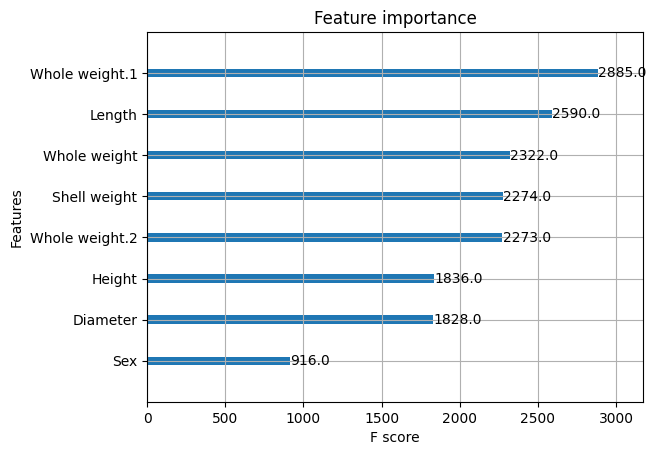

In [ ]:
plot_importance(xgb_model)

Similar to the random forest, sex seems to be the least important predictor.
Length seems to be the only differing facotr factor from the Random forst in importance.

In [ ]:
#xgb_preds = tensor(model.predict(X_test))

In [61]:
#rmse(xgb_preds, tensor(y_test))

In [62]:
dls = to.dataloaders(bs=64)

In [63]:
test_dl = dls.test_dl(test_df)

In [64]:
preds = tensor(model.predict(test_dl.xs))
xgb_preds = preds

XGBoost Submission code

In [65]:
submit = pd.read_csv(path/'sample_submission.csv')
submit['Rings'] = xgb_preds # nn_preds
submit.head()

,id,Rings
0,90615,9.718118
1,90616,9.864678
2,90617,10.131124
3,90618,9.839361
4,90619,7.558728


In [66]:
submit.to_csv('submission.csv', index=False)

In [67]:
!ls

kaggle.json  models  sample_data  submission.csv


In [68]:
sub = pd.read_csv('submission.csv')
sub.head()

,id,Rings
0,90615,9.718118
1,90616,9.864678
2,90617,10.131125
3,90618,9.839361
4,90619,7.558728


In [69]:
!kaggle competitions submit -c playground-series-s4e4 -f submission.csv -m "xgboost initial subm trial 5 without id column"

100% 963k/963k [00:01<00:00, 768kB/s]
Successfully submitted to Regression with an Abalone Dataset

###General Model Ensemble

XGBoost + Random Forest

In [85]:
avgs = (xgb_preds + rf_preds) / 2

In [70]:
avgs = (xgb_preds + nn_preds_y) / 2

In [ ]:
xgb_preds.shape,rf_preds.shape,nn_preds_y.shape

(torch.Size([60411]), torch.Size([60411]), torch.Size([60411]))

In [ ]:
avgs = (xgb_preds + nn_preds_y + rf_preds) / 3

In [ ]:
ens_preds_y

In [ ]:
avgs_ens = (xgb_preds + ens_preds_y + rf_preds) / 3

avgs_ens submission

In [ ]:
submit = pd.read_csv(path/'sample_submission.csv')
submit['Rings'] = avgs_ens # nn_preds
submit.head()

In [ ]:
submit.to_csv('submission.csv', index=False)

In [ ]:
!ls

models	sample_data


In [ ]:
sub = pd.read_csv('submission.csv')
sub.head()

In [ ]:
avgs.shape

torch.Size([60411])

In [72]:
!ls

kaggle.json  models  sample_data


avgs submission

In [86]:
submit = pd.read_csv(path/'sample_submission.csv')
submit['Rings'] = avgs # nn_preds
submit.head()

,id,Rings
0,90615,9.859058
1,90616,9.932339
2,90617,9.565562
3,90618,9.419681
4,90619,7.779364


In [87]:
submit.to_csv('submission.csv', index=False)

In [88]:
!ls

kaggle.json  models  sample_data  submission.csv


In [89]:
sub = pd.read_csv('submission.csv')
sub.head()

,id,Rings
0,90615,9.859058
1,90616,9.932339
2,90617,9.565562
3,90618,9.419681
4,90619,7.779364


In [90]:
!kaggle competitions submit -c playground-series-s4e4 -f submission.csv -m "rf preds + xgb_preds sub 1 with no id column all adjustment to test set preds"

100% 960k/960k [00:01<00:00, 770kB/s]
Successfully submitted to Regression with an Abalone Dataset

In [77]:
!kaggle competitions submit -c playground-series-s4e4 -f submission.csv -m "xgboost preds, nn_preds sub 1 with no id column all adjustment to test set preds"

100% 963k/963k [00:01<00:00, 773kB/s]
Successfully submitted to Regression with an Abalone Dataset

In [ ]:
#!kaggle competitions submit -c playground-series-s4e4 -f submission.csv -m "xgboost preds, nn_preds + random forest preds sub 3 with no id column all adjustment to test set preds"

100% 961k/961k [00:00<00:00, 2.28MB/s]
Successfully submitted to Regression with an Abalone Dataset